In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.cm as cm
import random
# from my_functions import get_img_array, get_run_logdir, get_model_dir, make_gradcam_heatmap, superimpose_gradcam

In [4]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [3]:
data_dir = 'datasetsSARS-COV-2 Ct-Scan'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2481 files belonging to 2 classes.
Using 1985 files for training.
Found 2481 files belonging to 2 classes.
Using 496 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['COVID-negative', 'COVID-positive']


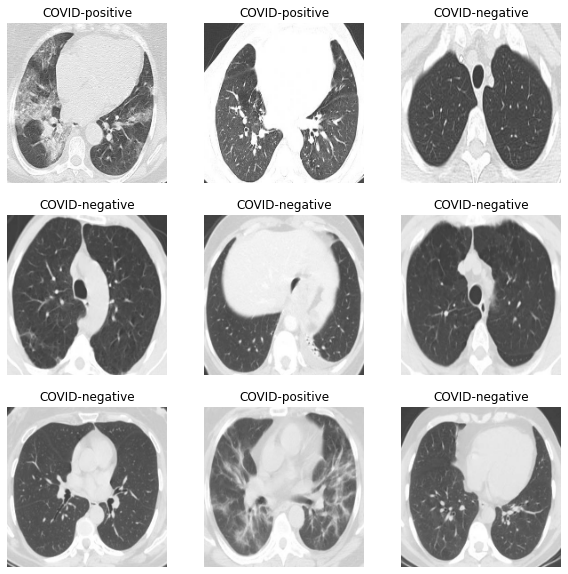

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
# base_model = keras.applications.Xception(
#     weights="imagenet",  # Load weights pre-trained on ImageNet.
#     input_shape=(img_height, img_width, 3),
#     include_top=False,
# )  # Do not include the ImageNet classifier at the top.

base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
)

In [6]:
inputs = keras.Input(shape=(img_height, img_width, 3))

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x) 
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

base_model.trainable = False # Freeze base model

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 4, 4, 128)         1769600   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0     

In [9]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

epochs = 100
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[tensorboard_cb, early_stopping_cb])

Epoch 1/100
63/63 [==============================] - 40s 284ms/step - loss: 1.4586 - accuracy: 0.6358 - val_loss: 0.5470 - val_accuracy: 0.7359
Epoch 2/100
63/63 [==============================] - 9s 147ms/step - loss: 0.5128 - accuracy: 0.7411 - val_loss: 0.3944 - val_accuracy: 0.8266
Epoch 3/100
63/63 [==============================] - 9s 150ms/step - loss: 0.4572 - accuracy: 0.7909 - val_loss: 0.4098 - val_accuracy: 0.8024
Epoch 4/100
63/63 [==============================] - 9s 150ms/step - loss: 0.4190 - accuracy: 0.8086 - val_loss: 0.4575 - val_accuracy: 0.8024
Epoch 5/100
63/63 [==============================] - 9s 147ms/step - loss: 0.3682 - accuracy: 0.8368 - val_loss: 0.3213 - val_accuracy: 0.8508
Epoch 6/100
63/63 [==============================] - 9s 147ms/step - loss: 0.3514 - accuracy: 0.8509 - val_loss: 0.3318 - val_accuracy: 0.8468
Epoch 7/100
63/63 [==============================] - 9s 147ms/step - loss: 0.3242 - accuracy: 0.8549 - val_loss: 0.3129 - val_accuracy: 0.871

In [10]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

epochs = 100

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[tensorboard_cb, early_stopping_cb])

run_modeldir = get_model_dir()
model.save(run_modeldir)

Epoch 1/100
63/63 [==============================] - 50s 541ms/step - loss: 0.1732 - accuracy: 0.9300 - val_loss: 0.2090 - val_accuracy: 0.9173
Epoch 2/100
63/63 [==============================] - 28s 445ms/step - loss: 0.1336 - accuracy: 0.9456 - val_loss: 0.1668 - val_accuracy: 0.9214
Epoch 3/100
63/63 [==============================] - 28s 449ms/step - loss: 0.1113 - accuracy: 0.9597 - val_loss: 0.1460 - val_accuracy: 0.9375
Epoch 4/100
63/63 [==============================] - 28s 452ms/step - loss: 0.0788 - accuracy: 0.9662 - val_loss: 0.1336 - val_accuracy: 0.9516
Epoch 5/100
63/63 [==============================] - 29s 454ms/step - loss: 0.0748 - accuracy: 0.9728 - val_loss: 0.1059 - val_accuracy: 0.9657
Epoch 6/100
63/63 [==============================] - 29s 462ms/step - loss: 0.0597 - accuracy: 0.9768 - val_loss: 0.2292 - val_accuracy: 0.9153
Epoch 7/100
63/63 [==============================] - 29s 467ms/step - loss: 0.0706 - accuracy: 0.9738 - val_loss: 0.1313 - val_accuracy:

In [14]:
img_path = "datasetsSARS-COV-2 Ct-Scan/COVID-positive/Covid (10).png"
img_array = (get_img_array(img_path, size=image_size))
preds = model.predict(img_array)
print(preds)

[[1.]]


In [13]:
# reconstructed_model : model
model = keras.models.load_model("my_models\\run_2021_10_30-15_43_55")

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 4, 4, 128)         1769600   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0     

Predicted: [[1.]]


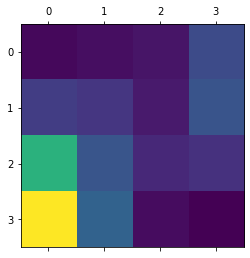

In [15]:
img_path = "datasetsSARS-COV-2 Ct-Scan/COVID-positive/Covid (10).png"

# Prepare image
img_array = (get_img_array(img_path, size=image_size))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heamap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv2d_203')

# Display heatmap
plt.matshow(heatmap)
plt.show()

Predicted: [[0.99998784]]


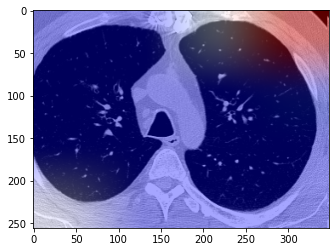

In [19]:
img_path = "datasetsSARS-COV-2 Ct-Scan/COVID-positive/Covid (100).png"
img_array = get_img_array(img_path, size=image_size)
superimposed_img = superimpose_gradcam(img_array=img_array, 
               current_model=model, 
               last_conv_layer_name='conv2d_203', 
               img_path=img_path, alpha=0.4)
imgplot = plt.imshow(superimposed_img)

img_array = (get_img_array(img_path, size=image_size))
preds = model.predict(img_array)
print("Predicted:", preds)

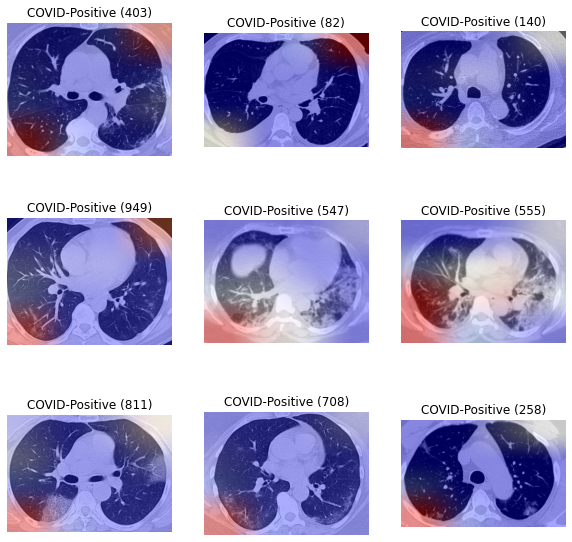

In [25]:
plt.figure(figsize=(10, 10))
for i in range(9):
  rand = random.randint(0, 1000)
  ax = plt.subplot(3, 3, i + 1)
  img_path = "datasetsSARS-COV-2 Ct-Scan/COVID-positive/Covid ({}).png".format(rand)
  img_array = get_img_array(img_path, size=image_size)
  superimposed_img = superimpose_gradcam(img_array, 
                    current_model=model, 
                    last_conv_layer_name='conv2d_203', 
                    img_path=img_path,
                    alpha=0.4)
  plt.imshow(superimposed_img)
  plt.title('COVID-Positive ({})'.format(rand))
  plt.axis("off")

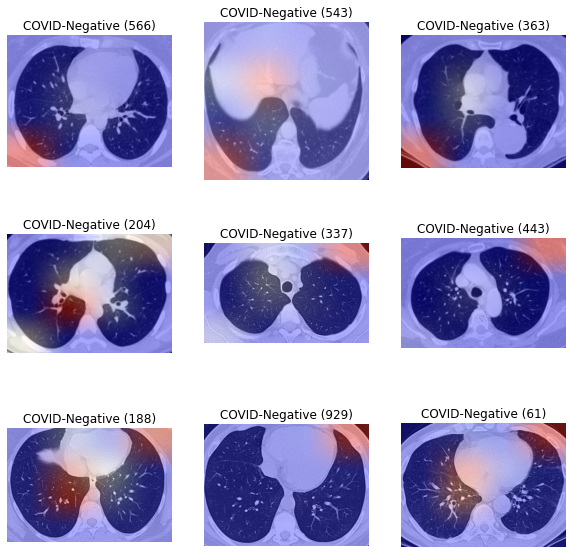

In [27]:
plt.figure(figsize=(10, 10))
for i in range(9):
  rand = random.randint(0, 1000)
  ax = plt.subplot(3, 3, i + 1)
  img_path = "datasetsSARS-COV-2 Ct-Scan/COVID-negative/Non-Covid ({}).png".format(rand)
  img_array = get_img_array(img_path, size=image_size)
  superimposed_img = superimpose_gradcam(img_array, 
                    current_model=model, 
                    last_conv_layer_name='conv2d_203', 
                    img_path=img_path,
                    alpha=0.4)
  plt.imshow(superimposed_img)
  plt.title('COVID-Negative ({})'.format(rand))
  plt.axis("off")